In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.8 MB/s eta 0:00:00


In [ ]:
# prompt: delete the file hyperparam_tuning in the uploaded files in google colab

!rm hyperparam_tuning

rm: cannot remove 'hyperparam_tuning': No such file or directory


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import keras_tuner as kt
import pandas as pd

# Load data and apply SMOTE
data = pd.read_csv('/content/creditcard.csv')
X = data.drop('Class', axis=1)
y = data['Class'].fillna(0)  # assuming non-fraud is the majority class

# Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for Conv1D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define a hypermodel for Keras Tuner
def build_model(hp):
    input_layer = Input(shape=(X_train.shape[1], 1))

    # Hyperparameter for the number of Conv1D layers and filters
    x = input_layer
    for i in range(hp.Int('num_conv_layers', 2, 4)):
        filters = hp.Int(f'filters_{i}', min_value=32, max_value=256, step=32)
        kernel_size = hp.Choice(f'kernel_size_{i}', values=[3, 5])
        x = Conv1D(filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        x = MaxPooling1D(pool_size=2)(x)
        x = Dropout(hp.Float(f'dropout_rate_{i}', 0.2, 0.5, step=0.1))(x)

    x = Flatten()(x)

    # Dense layer with tunable units and dropout rate
    dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=32)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(hp.Float('dropout_rate_dense', 0.3, 0.6, step=0.1))(x)

    # Output layer
    output_layer = Dense(1, activation='sigmoid')(x)

    # Compile model
    model = Model(inputs=input_layer, outputs=output_layer)
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Set up Keras Tuner for hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='fraud_detection_cnn_tuning'
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Run the hyperparameter search
tuner.search(X_train, y_train, epochs=5, batch_size=256, validation_split=0.2,
             callbacks=[early_stopping, reduce_lr], verbose=1)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the final CNN model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Final CNN Model Test Accuracy: {test_accuracy:.4f}')


Trial 1 Complete [00h 51m 46s]
val_accuracy: 0.9993405342102051

Best val_accuracy So Far: 0.9993405342102051
Total elapsed time: 00h 51m 46s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
2                 |4                 |num_conv_layers
96                |256               |filters_0
3                 |3                 |kernel_size_0
0.4               |0.4               |dropout_rate_0
256               |128               |filters_1
3                 |5                 |kernel_size_1
0.3               |0.2               |dropout_rate_1
96                |160               |dense_units
0.4               |0.3               |dropout_rate_dense
0.0056189         |0.00062558        |learning_rate
256               |32                |filters_2
3                 |3                 |kernel_size_2
0.4               |0.2               |dropout_rate_2
160               |32                |filters_3
3                 |3                 |kernel_size_3
0.4   

3554/3554 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
F1 Score: 0.9990
Precision: 0.9982
Accuracy: 0.9990


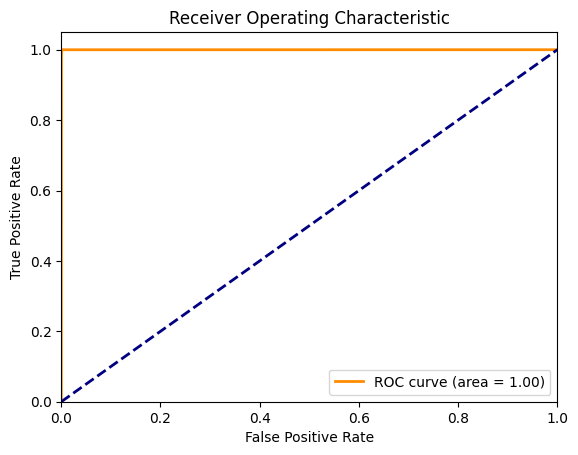

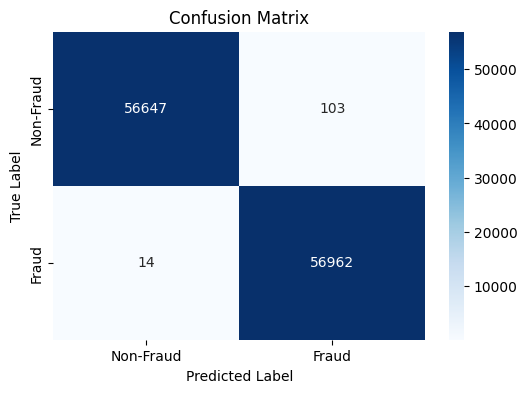

In [ ]:
# prompt: give the f1 score, precision, accuracy and auc curve of the predictions along with any other visual representations

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, accuracy_score, roc_curve, auc, confusion_matrix
import numpy as np
import seaborn as sns

# Get predictions from the best model
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate evaluation metrics
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()